In [2]:
import pathlib
import librosa

DATASET_DIR   = '../dataset/analysis'

input_wavs    = list(pathlib.Path(DATASET_DIR).glob('*wav'))
input_normal  = list(filter(lambda file_name: 'normal' in str(file_name), input_wavs))[0]
input_anomaly = list(filter(lambda file_name: 'ab'     in str(file_name), input_wavs))

print('[Input]')
print('Normal :', input_normal)
for wav_path in input_anomaly:
    print('Anomaly:', wav_path)


[Input]
Normal : ../dataset/analysis/normal_0003.wav
Anomaly: ../dataset/analysis/ab12_tail_pulley_excessive_tension.wav
Anomaly: ../dataset/analysis/ab06_belt_attached_metalic_object_2.wav
Anomaly: ../dataset/analysis/ab36_tension_pulley_excessive_tension.wav
Anomaly: ../dataset/analysis/ab72_tension_pulley_aging.wav
Anomaly: ../dataset/analysis/ab24_tail_pulley_removed.wav


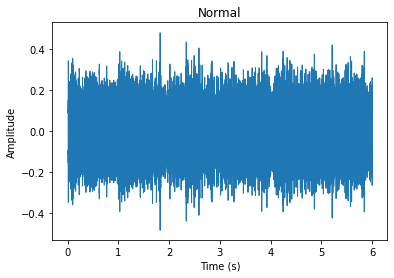

In [3]:
import librosa.display
import matplotlib.pyplot as plt

normal, sr = librosa.load(path=input_normal, offset=1.5, duration=6, sr=None, mono=True)

fig = plt.figure()
ax  = fig.add_subplot()
ax.set(title='Normal', ylabel='Amplitude')

librosa.display.waveshow(normal, sr, x_axis='s')
plt.show()

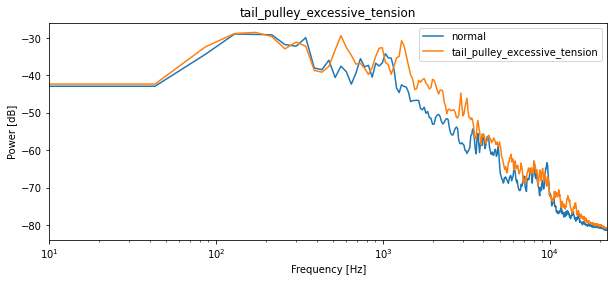

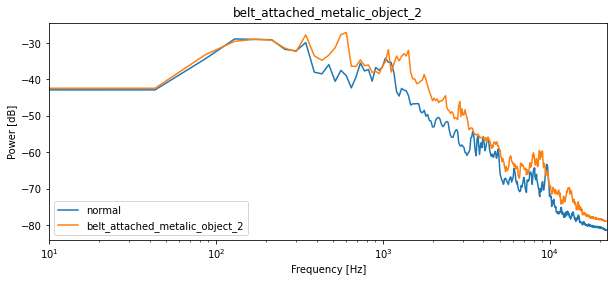

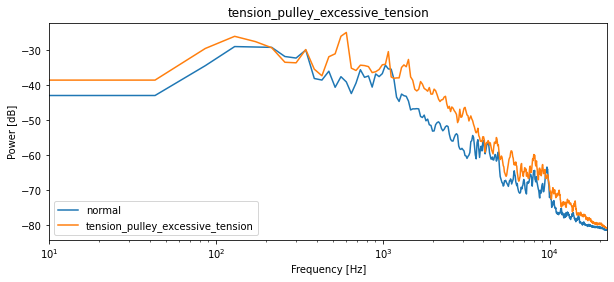

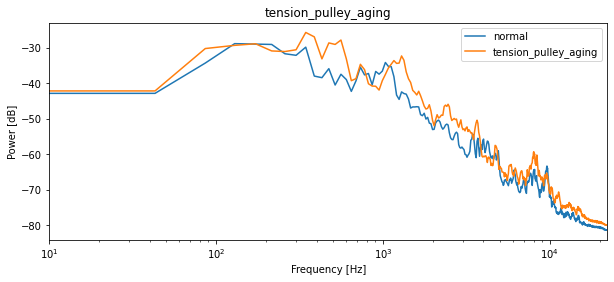

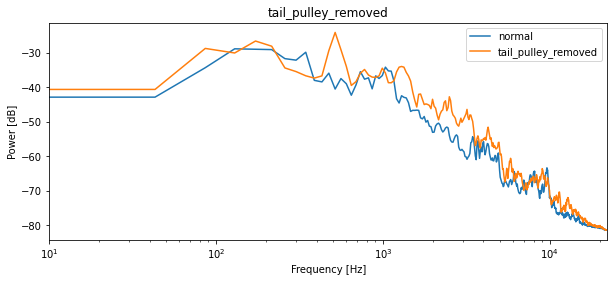

In [4]:
import numpy as np

WINDOW_SIZE = 1024

def do_fft(audio):

    audio_segment_list = list()
    while len(audio_segment_list) < (audio.size // WINDOW_SIZE):
        start_idx = len(audio_segment_list) * WINDOW_SIZE
        end_idx   = start_idx               + WINDOW_SIZE
        audio_segment_list.append(audio[start_idx : end_idx])

    fft_result = list()
    for audio_segment in audio_segment_list:
        fft          = np.fft.fft(audio_segment) / (WINDOW_SIZE / 2)
        fft_power    = (np.abs(fft) ** 2)[:WINDOW_SIZE // 2]
        fft_power_db = 10 * np.log10(fft_power)
        fft_result.append(fft_power_db)

    return np.mean(fft_result, axis=0)

def show_spectrum(title, normal_y, anomaly_y, freq):
    fig = plt.figure(figsize=(10,4))
    ax  = fig.add_subplot()
    ax.plot(freq, normal_y,  label='normal')
    ax.plot(freq, anomaly_y, label=title)
    ax.set(title=title, xlabel='Frequency [Hz]', ylabel='Power [dB]', xlim=(10,22050))
    ax.set_xscale('log')
    ax.legend()
    plt.show()

freq = np.fft.fftfreq(WINDOW_SIZE, 1/sr)[:WINDOW_SIZE // 2]

for input_ in input_anomaly:
    normal_y   = do_fft(normal)

    anomaly, _ = librosa.load(path=input_, offset=1.5, duration=6 ,sr=None, mono=True)
    anomaly_y  = do_fft(anomaly)

    title      = '_'.join(str(input_).split('_')[1:]).strip('.wav')

    show_spectrum(title, normal_y, anomaly_y, freq)


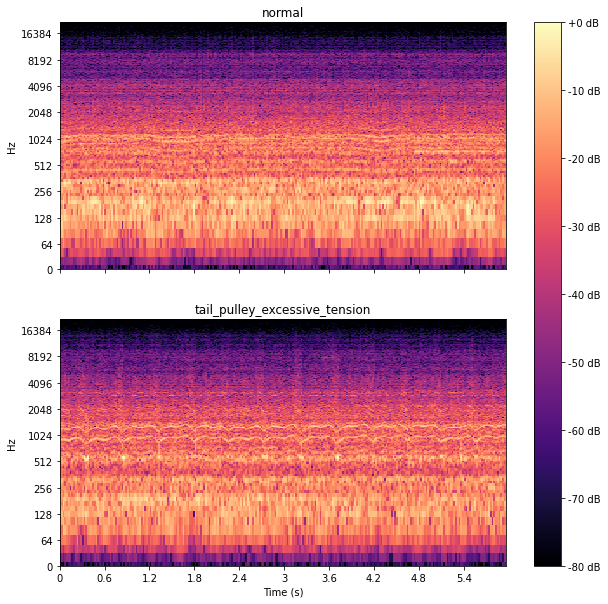

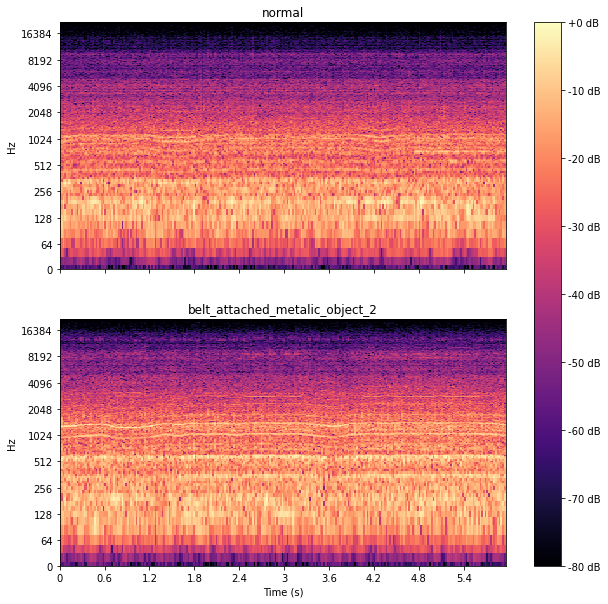

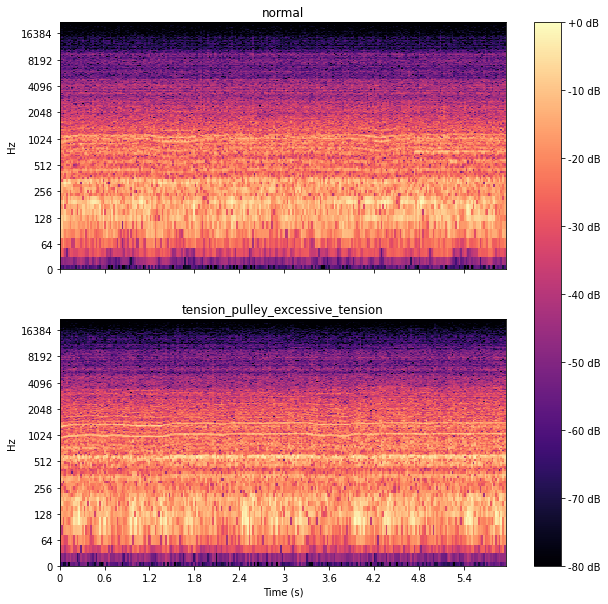

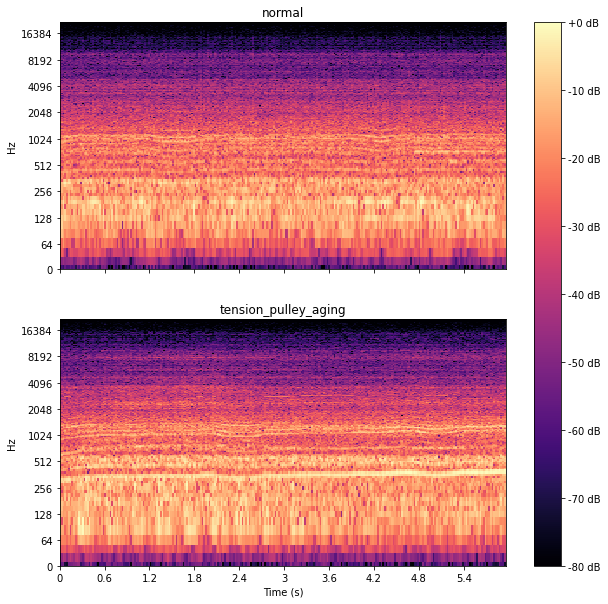

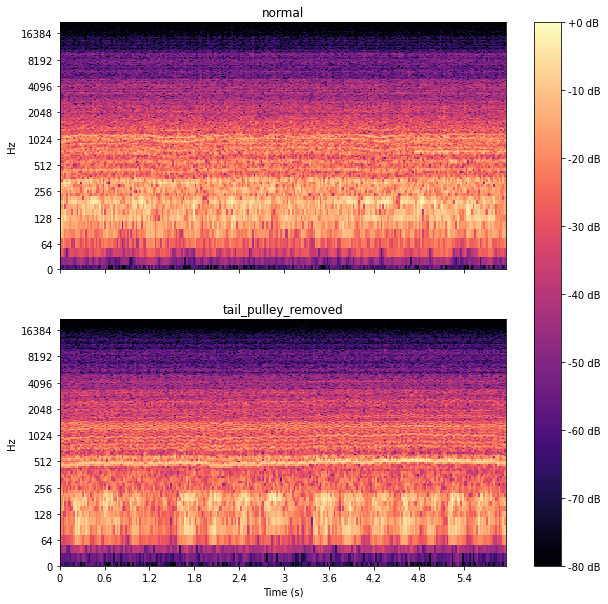

In [14]:
N_FFT       = 2048
HOP_LENGTH  = N_FFT // 2

def show_spectrogram(normal_spec, anomaly_spec, file_name):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
    img     = librosa.display.specshow(normal_spec,  sr=sr, hop_length=HOP_LENGTH, x_axis='s', y_axis='log', ax=ax[0])
    _       = librosa.display.specshow(anomaly_spec, sr=sr, hop_length=HOP_LENGTH, x_axis='s', y_axis='log', ax=ax[1])

    ax[0].set(title='normal')
    ax[0].label_outer()
    ax[1].set(title=file_name)
    ax[1].label_outer()

    fig.colorbar(img, ax=ax, format='%+2.f dB')
    plt.show()

normal_spec = librosa.amplitude_to_db(np.abs(librosa.stft(normal, n_fft=N_FFT, hop_length=HOP_LENGTH, center=True)), ref=np.max)

for input_ in input_anomaly:
    anomaly, _   = librosa.load(path=input_, offset=1.5, duration=6 ,sr=None, mono=True)
    anomaly_spec = librosa.amplitude_to_db(np.abs(librosa.stft(anomaly, n_fft=N_FFT, hop_length=HOP_LENGTH, center=True)), ref=np.max)
    file_name    = '_'.join(str(input_).split('_')[1:]).strip('.wav')
    show_spectrogram(normal_spec, anomaly_spec, file_name)
